# Imports

In [1]:
#!pip install opencv-python
#!pip install -U segmentation-models
## for openCV if required
#!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
#!pip install scikit-learn
#!pip install -U albumentations

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import keras_cv
from matplotlib import pyplot as plt
import cv2 as cv

import os
import random  # for sanity check
from PIL import Image

os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

import albumentations as A

2023-10-22 17:06:21.746338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 17:06:21.746369: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 17:06:21.746391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 17:06:21.752695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


# load GPU

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-10-22 17:06:23.971921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:23.976629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:23.976783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6986187078438736719
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3503226880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11131586948274471084
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 980, pci bus id: 0000:01:00.0, compute capability: 5.2"
xla_global_id: 416903419
]


2023-10-22 17:06:23.999062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:23.999231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:23.999351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Inside

## First some dataset information after thorough investigation 
984 images total, 725 in Train folder and 264 in Test. Nothing is labeled.  
some interesting features of dataset:
1) There is only 2 locations: winter and summer;
2) There are sometimes really hard situations: rails are hard to see, someone\something blocked the view, no rails or one "rail", not rails, many rails, the rails go at an angle etc.;
3) Test and Train data come from one common pool of images. Test data is resemble train, so neural net should work pretty good; But it will be interesting to see how NN work on images from other pool of images, for example, similar images from internet, other locations;
There were selected;
4) Images have different size.  

Considering different problems with rails (2), taking (3) into account, neural network should work pretty good for given Test data.  
But for NN I need labeled data, the more the better.


#### Labeling data

My task is detecting rails.  
First thing first, there are different approach to labeling:
- Should I label railway that I do not see (rails that blocked by someone or something)? or I need to cut out person or transport or smth else?
- Should I label other class than rails? It can help model to distinguish rails better.
- Is this semantic or Instance segmentation problem?


For simplicity, this is one-class problem. 1 is rails, 0 is backround.  
I manually selected 89 images and labeled all rails. If rails are not seen(block by someone\something), I did not marked rails, e.g. I did not tried to think "where rails should go".( Exception is rails under snow: I tried to predict where rails are and *wanted* to NN to solve this problem)

### Metrics and loss function

This is one-class semantic(for simplicity) segmentation problem.  
Appropriate metric for this type of problem is IoU (intersection over Union).  
Loss function is Jaccard index (it is the same as IoU, perfect function for this problem).  
It will be 1 if model is perfectly match all pixels, and 0 otherwise.

IoU is some sort of accuracy of object detection.  
Clear accuracy metric is bad metric since we have very sparse data and model predicting all 0 will have high accuracy

# loading data

In [6]:
def image_preparation(img_path, size):
    img = cv.imread(img_path, cv.COLOR_BGR2RGB)
    # convert to float
    if img.dtype == np.uint8:
        img = img / 255
    img = img.astype(np.float64)
    # resize img
    img = cv.resize(img, size)
    return img

def load_data(path="data/", size=None, load_mask=True):
    """masked images must be in same directory"""
    assert size is not None
    assert isinstance(size, tuple), f'wrong type of size. size mustbe tuple, got: {type(size)}'
    assert len(size) == 2, f"size len must be 2, got: {len(size)}"
    images = []
    masks = []
    for item in os.listdir(path):
        if item[-3:] != 'jpg':  # jpg is photo, png is mask. skip mask for now, wi want to have array of imgs and mask with equal index
            continue
        path_img = path + item
        img = image_preparation(path_img, size)
        images.append(img)
        if load_mask:
            path_mask = path + item[:-4] + '_mask.png'
            mask = image_preparation(path_mask, size)
            # truncate binary image to 1
            mask[mask > 0] = 1
            mask = mask.reshape(size[0], size[1], 1)  # 1 for binary channel
            masks.append(mask)
    images = np.array(images)
    if not load_mask:  # return only image_dataset
        return images
    masks = np.array(masks)
    return images, masks
    

In [7]:
IMG_SIZE = (512, 512)
images_dataset, mask_dataset = load_data(path='data/all_data_together/', size=IMG_SIZE)

In [8]:
print('images shape: ', images_dataset.shape)
print('mask shape: ', mask_dataset.shape)
print('max pixel value in image_dataset:', images_dataset.max())
print('min pixel value in image_dataset:', images_dataset.min())
print('Labels in the masks are: ', np.unique(mask_dataset))

images shape:  (89, 512, 512, 3)
mask shape:  (89, 512, 512, 1)
max pixel value in image_dataset: 1.0
min pixel value in image_dataset: 0.0
Labels in the masks are:  [0. 1.]


#### everything seems good

In [9]:
IMG_HEIGHT = images_dataset.shape[1]
IMG_WIDTH  = images_dataset.shape[2]
IMG_CHANNELS = images_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# split the data
with cross validation will be too big performance issue, so i need to take some data for validation.
Test data will stay unlabeled and will be evaluated visually

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(images_dataset, mask_dataset, test_size=0.2, random_state=42)

# Check the data
Sanity check, view few images just to sure that mask and images index are match

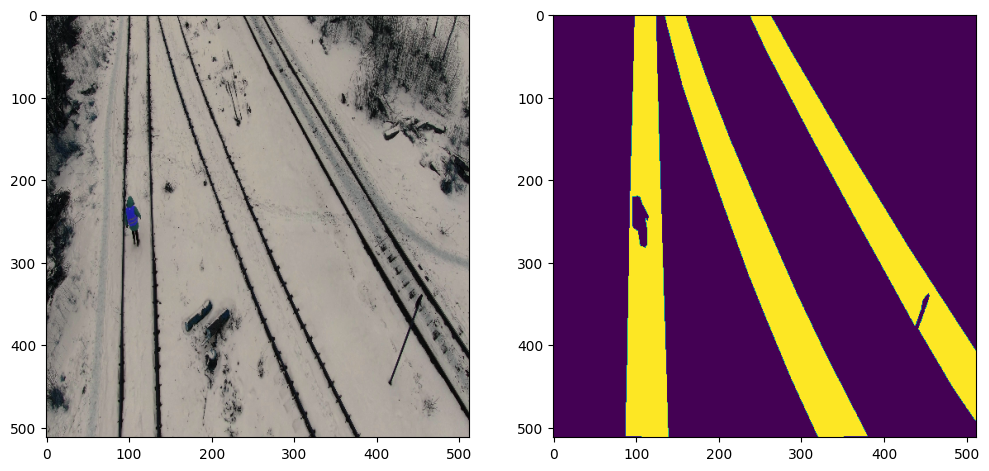

In [11]:
image_number = random.randint(0, len(x_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x_train[image_number])
plt.subplot(122)
plt.imshow(y_train[image_number])
plt.show()

# some helpful function (and class)

## plot loss and metric
helpful function for plotting loss and metrric

In [12]:
def make_plots_loss_metric(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    # setup loss plot
    plt.title('loss plot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss_value')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.subplot(122)
    #setup metric plot
    plt.title('iou_score plot')
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.ylabel('iou score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

helpful function to plot 3 images side-by-side

In [13]:
def make_plots_result(image_orig=None, ground_truth=None, model_pred=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(231)
    # original image
    if image_orig is not None:
        plt.title('original image')
        plt.imshow(image_orig)
        plt.axis('off')
    # ground truth
    if ground_truth is not None:
        plt.subplot(232)
        plt.title('ground truth')
        plt.imshow(ground_truth)
        plt.axis('off')
    # model prediction
    if model_pred is not None:
        plt.subplot(233)
        plt.title('model prediction')
        plt.imshow(model_pred)
        plt.axis('off')
    plt.show()

## Callback
to see how model handle unseen data from epoch to epoch ( each 5 epoch, if more precisely)

Callback described above.  
it loads data and see, how model perform prediction on loaded data ( should be valid data for better presentation)

In [14]:
class ShowResultsDuringTraining(keras.callbacks.Callback):
    def __init__(self, x, y_true, n_epoch=5):
        self.x = x
        self.y = y_true
        self.n_epoch = n_epoch
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n_epoch != 0:
            return
        y_pred = self.model.predict(self.x.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))[0]
        make_plots_result(self.x, self.y, y_pred)
         

### select image to check model work
This image will be loaded to callback and model will be evaluated on it in real-time

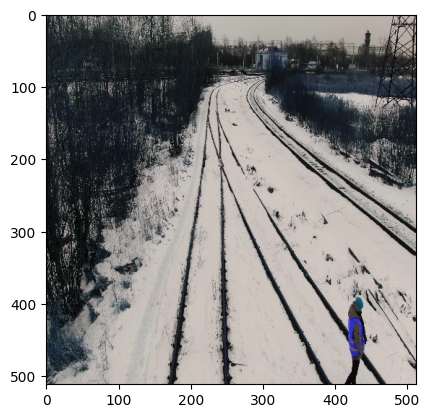

In [15]:
id = 17
plt.imshow(x_valid[id])

# Training model

## use pretrained u-net
pretrained u-net model will be baseline

2023-10-22 17:06:41.430741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:41.430937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 17:06:41.431077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/125


2023-10-22 17:06:58.873653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-22 17:07:00.068830: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-22 17:07:00.623375: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-22 17:07:00.807699: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

35/36 [============================>.] - ETA: 0s - loss: 1.3285 - iou_score: 0.1566

2023-10-22 17:07:23.221472: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-22 17:07:23.721241: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 1s 1s/step- loss: 1.3324 - iou_score: 0.15


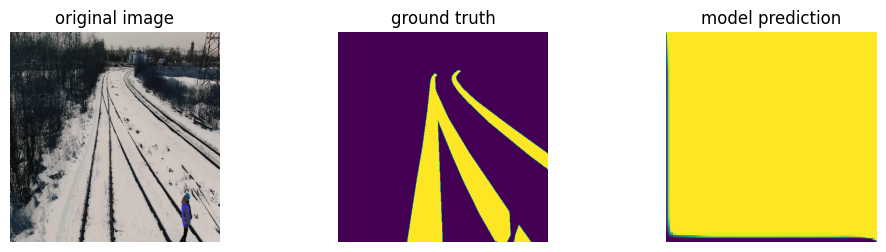

36/36 [==============================] - 46s 446ms/step - loss: 1.3324 - iou_score: 0.1556 - val_loss: 67.9027 - val_iou_score: 0.1534
Epoch 2/125
36/36 [==============================] - 9s 263ms/step - loss: 1.0961 - iou_score: 0.2526 - val_loss: 102683.6562 - val_iou_score: 0.0045
Epoch 3/125
36/36 [==============================] - 9s 263ms/step - loss: 0.9748 - iou_score: 0.3412 - val_loss: 9196.2295 - val_iou_score: 0.1530
Epoch 4/125
36/36 [==============================] - 9s 264ms/step - loss: 0.8736 - iou_score: 0.4105 - val_loss: 1.3955 - val_iou_score: 0.0652
Epoch 5/125
36/36 [==============================] - 9s 263ms/step - loss: 0.7851 - iou_score: 0.4759 - val_loss: 1.3549 - val_iou_score: 0.0758
Epoch 6/125
1/1 [==============================] - 0s 23ms/steploss: 0.7141 - iou_score: 0.51


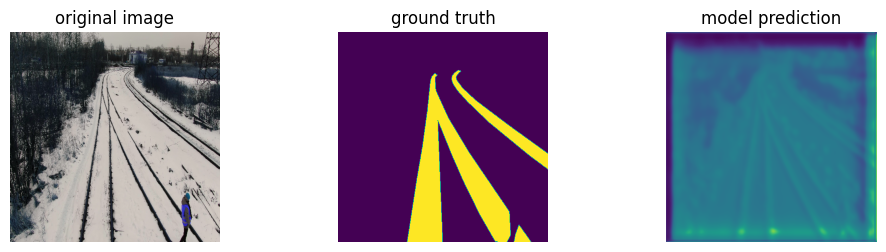

36/36 [==============================] - 10s 272ms/step - loss: 0.7141 - iou_score: 0.5161 - val_loss: 1.3412 - val_iou_score: 0.0863
Epoch 7/125
36/36 [==============================] - 9s 263ms/step - loss: 0.6184 - iou_score: 0.5855 - val_loss: 1.3684 - val_iou_score: 0.0699
Epoch 8/125
36/36 [==============================] - 9s 263ms/step - loss: 0.6091 - iou_score: 0.5955 - val_loss: 1.9299 - val_iou_score: 0.1465
Epoch 9/125
36/36 [==============================] - 9s 263ms/step - loss: 0.6121 - iou_score: 0.6021 - val_loss: 298.3983 - val_iou_score: 0.0012
Epoch 10/125
36/36 [==============================] - 9s 264ms/step - loss: 0.5425 - iou_score: 0.6356 - val_loss: 8.1624 - val_iou_score: 0.0017
Epoch 11/125
1/1 [==============================] - 0s 23ms/steploss: 0.5324 - iou_score: 0.64


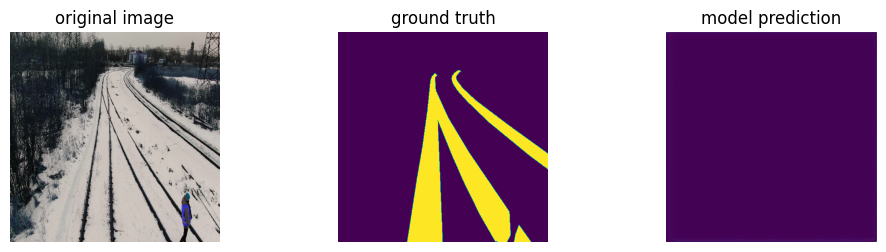

36/36 [==============================] - 10s 272ms/step - loss: 0.5324 - iou_score: 0.6454 - val_loss: 1.9491 - val_iou_score: 0.0022
Epoch 12/125
36/36 [==============================] - 9s 264ms/step - loss: 0.4424 - iou_score: 0.7048 - val_loss: 1.9873 - val_iou_score: 0.0017
Epoch 13/125
36/36 [==============================] - 9s 264ms/step - loss: 0.4976 - iou_score: 0.6605 - val_loss: 1.9564 - val_iou_score: 0.0021
Epoch 14/125
36/36 [==============================] - 9s 263ms/step - loss: 0.4570 - iou_score: 0.7012 - val_loss: 1.9680 - val_iou_score: 0.0019
Epoch 15/125
36/36 [==============================] - 9s 263ms/step - loss: 0.3588 - iou_score: 0.7626 - val_loss: 2.5925 - val_iou_score: 5.0893e-04
Epoch 16/125
1/1 [==============================] - 0s 23ms/steploss: 0.3961 - iou_score: 0.73


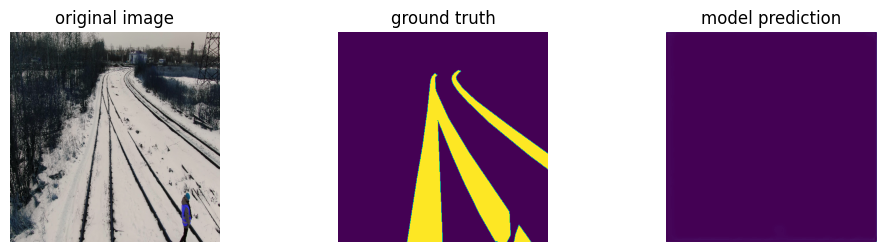

36/36 [==============================] - 10s 271ms/step - loss: 0.3961 - iou_score: 0.7384 - val_loss: 2.2083 - val_iou_score: 4.6036e-04
Epoch 17/125
36/36 [==============================] - 9s 264ms/step - loss: 0.3652 - iou_score: 0.7556 - val_loss: 2.1914 - val_iou_score: 5.1430e-04
Epoch 18/125
36/36 [==============================] - 9s 263ms/step - loss: 0.3564 - iou_score: 0.7635 - val_loss: 35.0888 - val_iou_score: 0.1476
Epoch 19/125
36/36 [==============================] - 9s 263ms/step - loss: 0.3542 - iou_score: 0.7699 - val_loss: 2.1939 - val_iou_score: 4.4522e-04
Epoch 20/125
36/36 [==============================] - 9s 263ms/step - loss: 0.3881 - iou_score: 0.7421 - val_loss: 2.0814 - val_iou_score: 0.0025
Epoch 21/125
1/1 [==============================] - 0s 22ms/steploss: 0.3496 - iou_score: 0.76


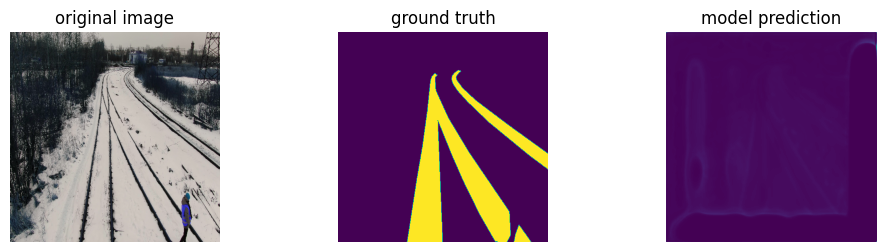

36/36 [==============================] - 10s 272ms/step - loss: 0.3496 - iou_score: 0.7686 - val_loss: 2.4074 - val_iou_score: 0.0011
Epoch 22/125
36/36 [==============================] - 9s 264ms/step - loss: 0.3758 - iou_score: 0.7492 - val_loss: 2.2825 - val_iou_score: 5.6427e-04
Epoch 23/125
36/36 [==============================] - 9s 264ms/step - loss: 0.3370 - iou_score: 0.7694 - val_loss: 2.1713 - val_iou_score: 8.4050e-04
Epoch 24/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2896 - iou_score: 0.8039 - val_loss: 2.1476 - val_iou_score: 0.0062
Epoch 25/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2480 - iou_score: 0.8391 - val_loss: 1.8763 - val_iou_score: 0.0643
Epoch 26/125
1/1 [==============================] - 0s 22ms/steploss: 0.2652 - iou_score: 0.81


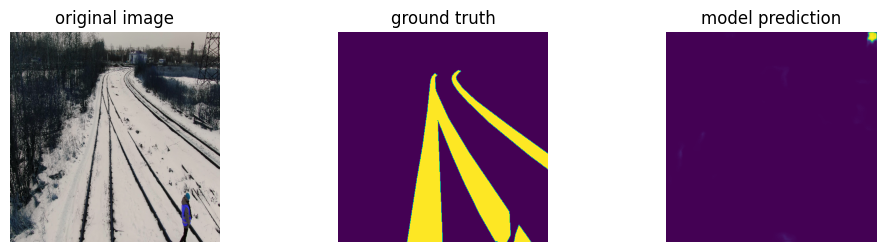

36/36 [==============================] - 10s 272ms/step - loss: 0.2652 - iou_score: 0.8162 - val_loss: 1.9147 - val_iou_score: 0.1130
Epoch 27/125
36/36 [==============================] - 10s 265ms/step - loss: 0.2158 - iou_score: 0.8594 - val_loss: 1.9379 - val_iou_score: 0.1293
Epoch 28/125
36/36 [==============================] - 10s 265ms/step - loss: 0.2367 - iou_score: 0.8233 - val_loss: 1.6162 - val_iou_score: 0.2147
Epoch 29/125
36/36 [==============================] - 10s 266ms/step - loss: 0.2668 - iou_score: 0.8166 - val_loss: 1.0261 - val_iou_score: 0.4637
Epoch 30/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2672 - iou_score: 0.8178 - val_loss: 0.5917 - val_iou_score: 0.6902
Epoch 31/125
1/1 [==============================] - 0s 22ms/steploss: 0.2710 - iou_score: 0.82


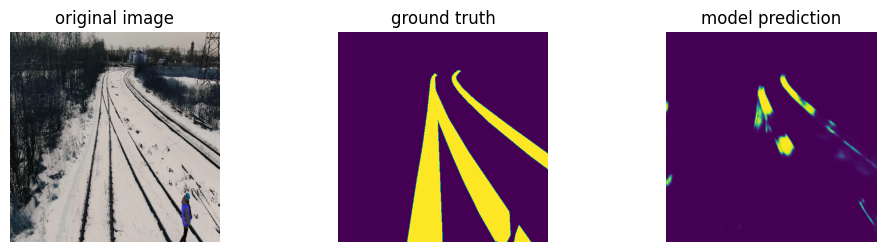

36/36 [==============================] - 10s 273ms/step - loss: 0.2710 - iou_score: 0.8256 - val_loss: 1.4203 - val_iou_score: 0.2908
Epoch 32/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2370 - iou_score: 0.8373 - val_loss: 0.6156 - val_iou_score: 0.6521
Epoch 33/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2352 - iou_score: 0.8332 - val_loss: 1.0557 - val_iou_score: 0.4104
Epoch 34/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2367 - iou_score: 0.8431 - val_loss: 0.5485 - val_iou_score: 0.6649
Epoch 35/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2159 - iou_score: 0.8588 - val_loss: 0.5711 - val_iou_score: 0.6680
Epoch 36/125
1/1 [==============================] - 0s 22ms/steploss: 0.1900 - iou_score: 0.87


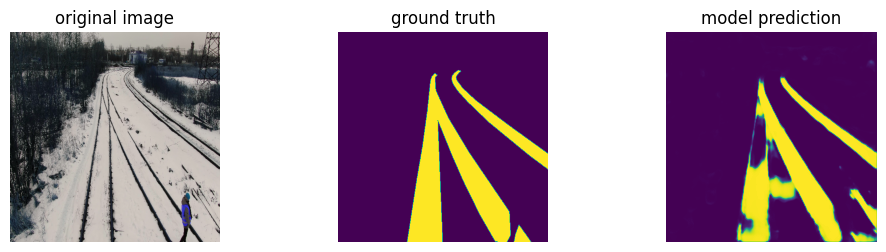

36/36 [==============================] - 10s 272ms/step - loss: 0.1900 - iou_score: 0.8715 - val_loss: 0.3691 - val_iou_score: 0.7656
Epoch 37/125
36/36 [==============================] - 9s 263ms/step - loss: 0.2150 - iou_score: 0.8567 - val_loss: 0.5503 - val_iou_score: 0.6798
Epoch 38/125
36/36 [==============================] - 10s 265ms/step - loss: 0.2207 - iou_score: 0.8504 - val_loss: 0.4396 - val_iou_score: 0.7185
Epoch 39/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1983 - iou_score: 0.8647 - val_loss: 0.8776 - val_iou_score: 0.4881
Epoch 40/125
36/36 [==============================] - 10s 265ms/step - loss: 0.2545 - iou_score: 0.8293 - val_loss: 0.8903 - val_iou_score: 0.4830
Epoch 41/125
1/1 [==============================] - 0s 22ms/steploss: 0.1947 - iou_score: 0.86


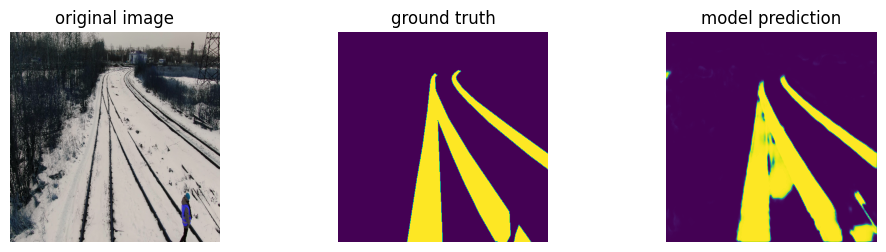

36/36 [==============================] - 10s 273ms/step - loss: 0.1947 - iou_score: 0.8695 - val_loss: 0.3722 - val_iou_score: 0.7665
Epoch 42/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2275 - iou_score: 0.8393 - val_loss: 0.3019 - val_iou_score: 0.8186
Epoch 43/125
36/36 [==============================] - 9s 264ms/step - loss: 0.1767 - iou_score: 0.8794 - val_loss: 0.4953 - val_iou_score: 0.6970
Epoch 44/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1786 - iou_score: 0.8795 - val_loss: 0.3779 - val_iou_score: 0.7684
Epoch 45/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1778 - iou_score: 0.8787 - val_loss: 0.5329 - val_iou_score: 0.6832
Epoch 46/125
1/1 [==============================] - 0s 24ms/steploss: 0.1983 - iou_score: 0.85


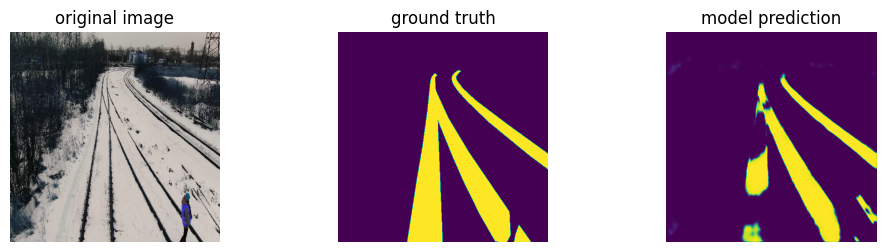

36/36 [==============================] - 10s 273ms/step - loss: 0.1983 - iou_score: 0.8585 - val_loss: 0.4937 - val_iou_score: 0.7104
Epoch 47/125
36/36 [==============================] - 9s 264ms/step - loss: 0.1445 - iou_score: 0.9006 - val_loss: 0.3889 - val_iou_score: 0.7639
Epoch 48/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1343 - iou_score: 0.9072 - val_loss: 0.3681 - val_iou_score: 0.7671
Epoch 49/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1502 - iou_score: 0.8873 - val_loss: 0.3538 - val_iou_score: 0.7899
Epoch 50/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1123 - iou_score: 0.9209 - val_loss: 0.3769 - val_iou_score: 0.7812
Epoch 51/125
1/1 [==============================] - 0s 21ms/steploss: 0.1068 - iou_score: 0.92


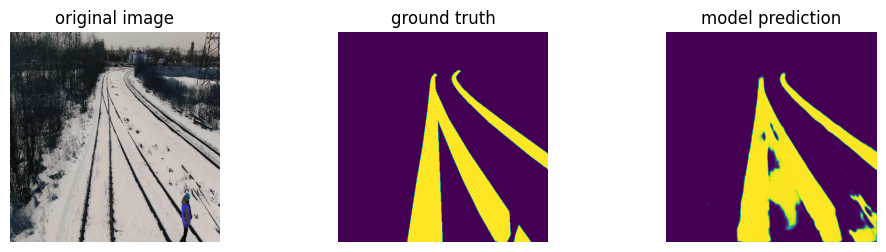

36/36 [==============================] - 10s 273ms/step - loss: 0.1068 - iou_score: 0.9255 - val_loss: 0.4239 - val_iou_score: 0.7647
Epoch 52/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1116 - iou_score: 0.9205 - val_loss: 0.5126 - val_iou_score: 0.7119
Epoch 53/125
36/36 [==============================] - 10s 266ms/step - loss: 0.1022 - iou_score: 0.9291 - val_loss: 0.3323 - val_iou_score: 0.8146
Epoch 54/125
36/36 [==============================] - 10s 266ms/step - loss: 0.0979 - iou_score: 0.9304 - val_loss: 0.3494 - val_iou_score: 0.8019
Epoch 55/125
36/36 [==============================] - 10s 266ms/step - loss: 0.0976 - iou_score: 0.9310 - val_loss: 0.3603 - val_iou_score: 0.7982
Epoch 56/125
1/1 [==============================] - 0s 22ms/steploss: 0.1195 - iou_score: 0.90


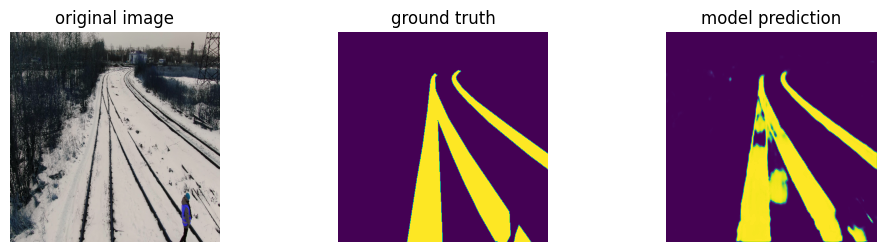

36/36 [==============================] - 10s 273ms/step - loss: 0.1195 - iou_score: 0.9092 - val_loss: 0.3744 - val_iou_score: 0.7875
Epoch 57/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1010 - iou_score: 0.9299 - val_loss: 0.3691 - val_iou_score: 0.7976
Epoch 58/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1415 - iou_score: 0.8860 - val_loss: 0.4216 - val_iou_score: 0.7752
Epoch 59/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1494 - iou_score: 0.8882 - val_loss: 0.3922 - val_iou_score: 0.7904
Epoch 60/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1209 - iou_score: 0.9168 - val_loss: 0.3476 - val_iou_score: 0.8129
Epoch 61/125
1/1 [==============================] - 0s 22ms/steploss: 0.2095 - iou_score: 0.86


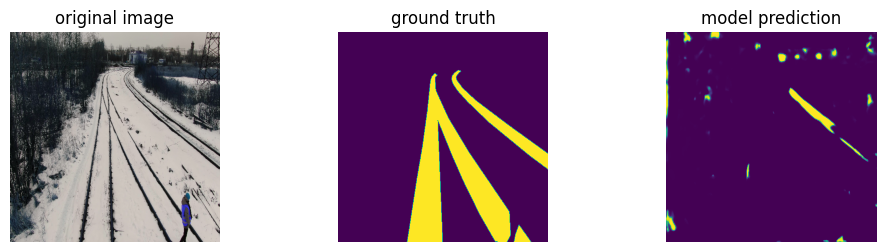

36/36 [==============================] - 10s 274ms/step - loss: 0.2095 - iou_score: 0.8604 - val_loss: 1.2369 - val_iou_score: 0.4806
Epoch 62/125
36/36 [==============================] - 9s 264ms/step - loss: 0.2030 - iou_score: 0.8511 - val_loss: 0.6530 - val_iou_score: 0.6542
Epoch 63/125
36/36 [==============================] - 10s 280ms/step - loss: 0.2033 - iou_score: 0.8607 - val_loss: 0.6457 - val_iou_score: 0.6278
Epoch 64/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1946 - iou_score: 0.8644 - val_loss: 0.5336 - val_iou_score: 0.6978
Epoch 65/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1800 - iou_score: 0.8762 - val_loss: 0.4764 - val_iou_score: 0.7232
Epoch 66/125
1/1 [==============================] - 0s 22ms/steploss: 0.1670 - iou_score: 0.87


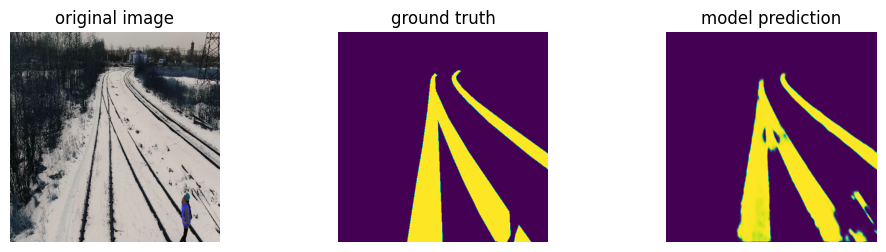

36/36 [==============================] - 10s 274ms/step - loss: 0.1670 - iou_score: 0.8781 - val_loss: 0.3679 - val_iou_score: 0.7845
Epoch 67/125
36/36 [==============================] - 10s 265ms/step - loss: 0.1091 - iou_score: 0.9236 - val_loss: 0.3561 - val_iou_score: 0.7881
Epoch 68/125
36/36 [==============================] - 10s 266ms/step - loss: 0.0962 - iou_score: 0.9317 - val_loss: 0.3209 - val_iou_score: 0.8118
Epoch 69/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0914 - iou_score: 0.9352 - val_loss: 0.3458 - val_iou_score: 0.8028
Epoch 70/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0853 - iou_score: 0.9399 - val_loss: 0.3540 - val_iou_score: 0.8072
Epoch 71/125
1/1 [==============================] - 0s 23ms/steploss: 0.0870 - iou_score: 0.93


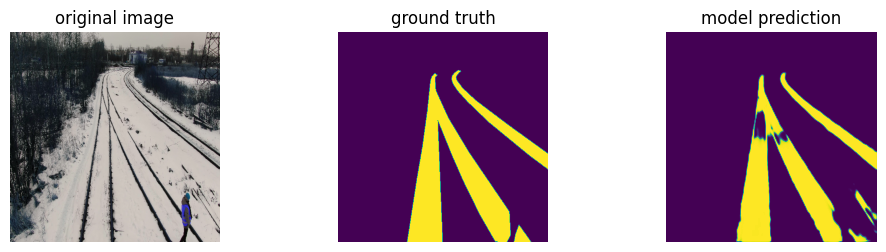

36/36 [==============================] - 10s 274ms/step - loss: 0.0870 - iou_score: 0.9381 - val_loss: 0.3624 - val_iou_score: 0.8058
Epoch 72/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0792 - iou_score: 0.9427 - val_loss: 0.3584 - val_iou_score: 0.8050
Epoch 73/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0801 - iou_score: 0.9423 - val_loss: 0.3605 - val_iou_score: 0.8134
Epoch 74/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0800 - iou_score: 0.9437 - val_loss: 0.3777 - val_iou_score: 0.8100
Epoch 75/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0753 - iou_score: 0.9467 - val_loss: 0.3739 - val_iou_score: 0.8083
Epoch 76/125
1/1 [==============================] - 0s 22ms/steploss: 0.0769 - iou_score: 0.94


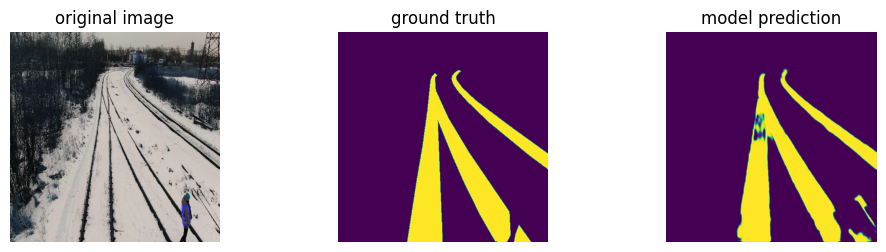

36/36 [==============================] - 10s 273ms/step - loss: 0.0769 - iou_score: 0.9446 - val_loss: 0.3890 - val_iou_score: 0.8019
Epoch 77/125
36/36 [==============================] - 10s 265ms/step - loss: 0.0781 - iou_score: 0.9450 - val_loss: 0.3855 - val_iou_score: 0.7976
Epoch 78/125
36/36 [==============================] - 10s 272ms/step - loss: 0.0752 - iou_score: 0.9462 - val_loss: 0.3903 - val_iou_score: 0.8029


In [16]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
# define model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", min_delta=1e8, patience=15,
                                                     restore_best_weights=True, start_from_epoch=62)

history = model.fit(x=x_train, y=y_train, batch_size=2, epochs=125, shuffle=True,
                    validation_data=(x_valid, y_valid), verbose=1,
                    callbacks=[ShowResultsDuringTraining(x_valid[id], y_valid[id]), earlyStopCallback]
)

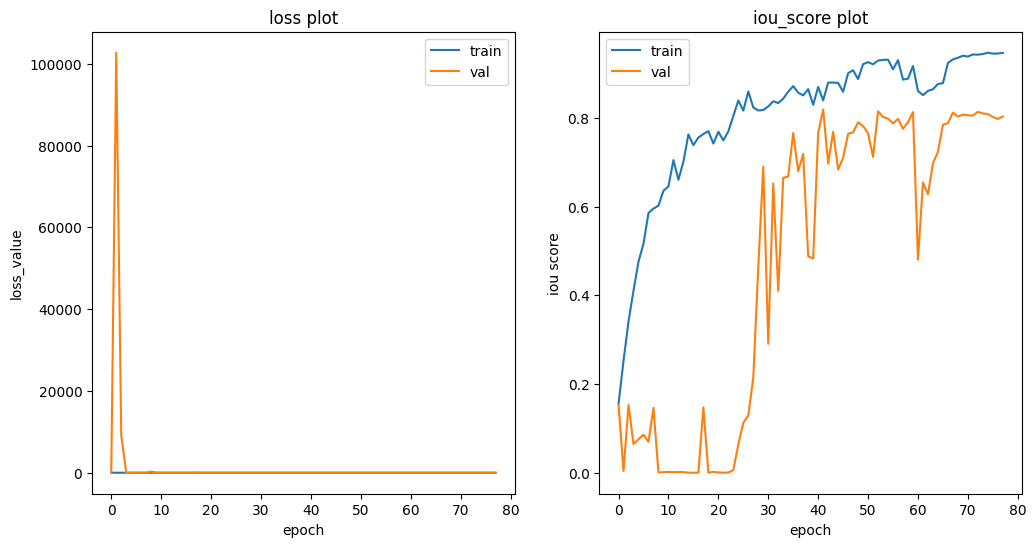

In [17]:
make_plots_loss_metric(history)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
# setup loss plot
plt.title('loss plot')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss_value')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper right')
plt.show()

The best valid iou score is about 0.80.  
Try to improve this score using data augmentation

### Save model weights

In [20]:
weights_path = 'weights/pretrained_unet_rails'
model.save_weights(weights_path, save_format='h5')

## use data augmentation

### Generate more data
After investigation different methods of augmentation, selected techniques will be combinined into one pipeline

In [ ]:
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),  # add horizontal, vertical, or both flip with p=.5
        A.Transpose(),
        A.RandomBrightnessContrast(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.ColorJitter(p=0.8, hue=0, brightness=(0.4, 1.0), contrast=(0.4, 1.0), saturation=(0.4,1.0)),
            A.Sharpen(p=0.4, alpha=(0.1, 0.7), lightness=(0.4, 1.0)),
            A.Emboss(alpha=(0.1, 0.7), strength=(0.3, 0.7), always_apply=False, p=0.4),
        ], p=0.5),
    ])
# uncomment below if want to see augmentation on some data
#random.seed(42)
#augmentated = transform(image=(x_train[23] *255).astype(np.uint8), mask=y_train[23])
#augmented_image = augmentated['image']
#augmented_mask = augmentated['mask']
#make_plots_result(augmented_image, augmented_mask)

### There are 2 ways when perform augmentation:
1) on-fly, during training;
2) generate augmentation data first before training, and then train NN with generated data

I chosed second variant

In [ ]:
def augment_img_and_mask(img, mask, n=10):
    augs_imgs = []
    augs_masks = []
    for i in range(n):
        augmentated = transform(image=img, mask=mask)
        augmented_image = augmentated['image']
        augmented_mask = augmentated['mask']
        augs_imgs.append(augmented_image)
        augs_masks.append(augmented_mask)
    augs_imgs = np.array(augs_imgs)
    augs_masks = np.array(augs_masks)
    return augs_imgs, augs_masks
    
    

In [ ]:
def generate_aug_data():
    augmented_x = []
    augmented_y = []
    for i in range(len(x_train)):
        a_imgs, a_masks = augment_img_and_mask((x_train[i]*255).astype(np.uint8), y_train[i])
        augmented_x.append([img for img in a_imgs])
        augmented_y.append([img for img in a_masks])
    augmented_x = np.array(augmented_x)
    augmented_y = np.array(augmented_y)
    # TODO remove duplication
    return augmented_x.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS ) / 255, augmented_y.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1).astype(float)

#### get augmented x and y

In [ ]:
augmented_x, augmented_y = generate_aug_data()

In [ ]:
i = random.randint(0, augmented_x.shape[0] - 1)
make_plots_result(augmented_x[i], augmented_y[i])

## train model on augmented data

In [ ]:
# pretrained model is too severe for my GPU, use lighter implementation without weights
#BACKBONE = 'resnet50'
#model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
#model.summary()

### Use own model

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    #x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64, 128]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        #x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        #x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32, 16]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        #x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        #x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model(input_shape, num_classes=1)
model.summary()

### Train model on augmented data

add callbacks

In [ ]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", min_delta=1e6, patience=15,
                                                     restore_best_weights=True, start_from_epoch=30)
ownCallback = ShowResultsDuringTraining(x_valid[id], y_valid[id])

In [ ]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
history = model.fit(augmented_x, augmented_y,
                    batch_size=1, epochs=125, shuffle=True,
                    validation_data=(x_valid, y_valid), verbose=1,
                    callbacks=[earlyStopCallback, ownCallback]
)

In [ ]:
make_plots_loss_metric(history)

# Summary

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
model.load_weights(weights_path)

## Results

re-run cell to see differentt images from x_valid and model predicton will be above picture

In [ ]:
i =random.randint(0, len(x_valid) - 1)
model_predict = model.predict(x_valid[i].reshape(1, IMG_WIDTH, IMG_HEIGHT,  IMG_CHANNELS))[0]

plt.figure(figsize=(9, 9))
plt.axis('off')
ax = plt.imshow(x_valid[i])
plt.imshow(model_predict, cmap='gray', alpha=0.5)

See some results on unlabeled test images.

In [ ]:
test_images_dataset = load_data(path='data/test/', size=IMG_SIZE)

In [ ]:
i =random.randint(0, len(test_images_dataset) - 1)


plt.figure(figsize=(9, 9))
plt.axis('off')
ax = plt.imshow(test_images_dataset[i])
plt.imshow(model_predict, cmap='gray', alpha=0.5)

In [ ]:
def plots_images(img_dataset):
    assert len(img_dataset) >= 9, 'need at least 9 images'
    n_images = 9
    ids = [random.randrange(0, len(img_dataset) - 1) for r in range(n_images)]
    rows = 3
    cols = 3
    fig, axs = plt.subplots(rows, cols, figsize=(12,12))
    for num, id in enumerate(ids):
        # one predict, not enough GPU memory to make all test_images
        plt.subplot(rows,cols,num+1)
        model_predict = model.predict(img_dataset[id].reshape(1, IMG_WIDTH, IMG_HEIGHT,  IMG_CHANNELS))[0]
        plt.imshow(img_dataset[id])
        plt.imshow(model_predict, cmap='gray', alpha=0.35)
        plt.axis('off')
        
    

In [ ]:
plots_images(test_images_dataset)

since test data is close to train, not suprised that model handle this type of data

See some results on other images from Internet (contains both rails and not rails)

In [ ]:
random_images_dataset = load_data(path='data/random/', size=IMG_SIZE)
random_images_dataset.shape

In [ ]:
plots_images(random_images_dataset)

## Ways to improve results

1) Try other model architectures;
2) Try other or add more variation in data augmentation, generate more data;
3) Gather more data and label more accurate
4) It is possible to improve results using openCV library. For example, using blur or Erosion operation will help to reduce amount of false positive (probably); and using Hough Transform for finding lines, it will reduce false negatives (probably).